In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3808473/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
MAX_BATCH_SIZE = 9
GPUS = 32
ORG_NAME = "DEAD FoundationsDAO"
SPLITS_FREQ = "2d"
LAST_FOLDS = 20
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-11-28"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29681 entries, 0 to 29680
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 29681 non-null  object        
 1   author             29681 non-null  object        
 2   date               29681 non-null  datetime64[us]
 3   start              29681 non-null  datetime64[us]
 4   end                5799 non-null   datetime64[us]
 5   platform_proposal  29681 non-null  object        
dtypes: datetime64[us](3), object(3)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17738 entries, 0 to 17737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        17738 non-null  object        
 1   proposal  17738 non-null  object        
 2   voter     17738 non-null  object        
 3   date      17738 non-null  datetime64[us]
dtyp

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DEAD FoundationsDAO/baseline/folds-info_2d_normalize.parquet
fold
2022-06-16    17723
2022-06-18    17723
2022-06-20    17723
2022-06-22    17723
2022-06-24    17723
2022-06-26    17723
2022-06-28    17723
2022-06-30    17737
2022-07-02    17737
2022-07-04    17737
2022-07-06    17737
2022-07-08    17737
2022-07-10    17737
2022-07-12    17737
2022-07-14    17737
2022-07-16    17737
2022-07-18    17737
2022-07-20    17737
2022-07-22    17737
2022-07-24    17737
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2022-W24,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W24,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W25,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W25,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W25,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W25,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W26,14,0,0,0.00,nan,14,1,1.00,14.00
2022-W26,14,14,1,1.00,14.00,0,0,0.00,nan
2022-W26,14,14,1,1.00,14.00,0,0,0.00,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2022-W24 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W24 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W25 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W25 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W25 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W25 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W26 & 14 & 0 & 0 & 0.00 & nan & 14 & 1 & 1.00 & 14.00 \\
2022-W26 & 14 & 14 & 1 & 1.00 & 14.00 & 0 & 0 & 0.00 & nan \\
2022-W26 & 14 & 14 & 1 & 1.00 & 14.00 & 0 & 0 & 0.00 & nan \\
2022-W27 & 14 & 14 & 1 & 1.00 & 14.00 & 0 & 0 & 0.00 & nan \\
2022-W27 & 14 & 14 & 1 & 1.00

## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/304 [00:00<?, ?it/s]

Warning, empty test fold 0 (2020-11-25 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2020-11-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2020-11-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2020-12-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2020-12-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2020-12-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2020-12-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2020-12-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 9 (2020-12-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 10 (2020-12-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 11 (2020-12-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 12 (2020-12-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 13 (2020-12-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 14 (2020-12-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 15 (2020-12-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 16 (2020-12-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 17 (2020-12-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 18 (2020-12-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 19 (2021-01-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 20 (2021-01-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 21 (2021-01-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 22 (2021-01-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 23 (2021-01-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 24 (2021-01-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 25 (2021-01-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 26 (2021-01-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 27 (2021-01-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 28 (2021-01-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 29 (2021-01-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 30 (2021-01-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 31 (2021-01-26 00:00:00), all ok since 1 folds ago


Warning, test fold 33 (2021-01-30 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, empty test fold 34 (2021-02-01 00:00:00), all ok since 3 folds ago
Warning, empty test fold 35 (2021-02-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 36 (2021-02-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 37 (2021-02-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 38 (2021-02-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 39 (2021-02-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 40 (2021-02-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 41 (2021-02-15 00:00:00), all ok since 1 folds ago


Warning, test fold 42 (2021-02-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago
Warning, empty test fold 43 (2021-02-19 00:00:00), all ok since 2 folds ago


Warning, empty test fold 44 (2021-02-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 45 (2021-02-23 00:00:00), all ok since 1 folds ago


Warning, test fold 46 (2021-02-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 47 (2021-02-27 00:00:00), all ok since 2 folds ago
Warning, empty test fold 48 (2021-03-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 49 (2021-03-03 00:00:00), all ok since 1 folds ago


Warning, test fold 51 (2021-03-07 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago
Warning, test fold 52 (2021-03-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 53 (2021-03-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, empty test fold 54 (2021-03-13 00:00:00), all ok since 5 folds ago


Warning, empty test fold 55 (2021-03-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 56 (2021-03-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 57 (2021-03-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 58 (2021-03-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 59 (2021-03-23 00:00:00), all ok since 1 folds ago
Warning, test fold 60 (2021-03-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 61 (2021-03-27 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 62 (2021-03-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 63 (2021-03-31 00:00:00), all ok since 4 folds ago
Warning, empty test fold 64 (2021-04-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 65 (2021-04-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 66 (2021-04-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 67 (2021-04-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 68 (2021-04-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 69 (2021-04-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 70 (2021-04-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 71 (2021-04-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 72 (2021-04-18 00:00:00), all ok since 1 folds ago


Warning, test fold 73 (2021-04-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 74 (2021-04-22 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 75 (2021-04-24 00:00:00), all ok since 3 folds ago
Warning, empty test fold 76 (2021-04-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 77 (2021-04-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 78 (2021-04-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 79 (2021-05-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 80 (2021-05-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 81 (2021-05-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 82 (2021-05-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 83 (2021-05-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 84 (2021-05-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 85 (2021-05-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 86 (2021-05-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 87 (2021-05-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 88 (2021-05-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 89 (2021-05-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 90 (2021-05-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 91 (2021-05-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 92 (2021-05-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 93 (2021-05-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 94 (2021-06-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 95 (2021-06-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 96 (2021-06-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 97 (2021-06-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 98 (2021-06-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 99 (2021-06-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 100 (2021-06-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 101 (2021-06-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 102 (2021-06-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 103 (2021-06-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 104 (2021-06-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 105 (2021-06-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 106 (2021-06-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 107 (2021-06-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 108 (2021-06-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 109 (2021-07-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 110 (2021-07-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 111 (2021-07-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 112 (2021-07-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 113 (2021-07-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 114 (2021-07-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 115 (2021-07-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 116 (2021-07-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 119 (2021-07-21 00:00:00), all ok since 3 folds ago
Warning, test fold 120 (2021-07-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 121 (2021-07-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 122 (2021-07-27 00:00:00), all ok since 1 folds ago


Warning, test fold 123 (2021-07-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 124 (2021-07-31 00:00:00), all ok since 2 folds ago
Warning, empty test fold 125 (2021-08-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 126 (2021-08-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 127 (2021-08-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 128 (2021-08-08 00:00:00), all ok since 1 folds ago
Warning, test fold 129 (2021-08-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 130 (2021-08-12 00:00:00), all ok since 2 folds ago
Warning, empty test fold 131 (2021-08-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 132 (2021-08-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 133 (2021-08-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 134 (2021-08-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 135 (2021-08-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 136 (2021-08-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 137 (2021-08-26 00:00:00), all ok since 1 folds ago
Warning, test fold 138 (2021-08-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 139 (2021-08-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 140 (2021-09-01 00:00:00), all ok since 3 folds ago


Warning, empty test fold 141 (2021-09-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 142 (2021-09-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 143 (2021-09-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 144 (2021-09-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 145 (2021-09-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 146 (2021-09-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 147 (2021-09-15 00:00:00), all ok since 1 folds ago
Warning, test fold 148 (2021-09-17 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 149 (2021-09-19 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 150 (2021-09-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 151 (2021-09-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 152 (2021-09-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 153 (2021-09-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 154 (2021-09-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 155 (2021-10-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 156 (2021-10-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 157 (2021-10-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 158 (2021-10-07 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 159 (2021-10-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 160 (2021-10-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 161 (2021-10-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 162 (2021-10-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 163 (2021-10-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 164 (2021-10-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 165 (2021-10-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 166 (2021-10-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 291 (2022-06-30 00:00:00), all ok since 144 folds ago
Warning, empty test fold 292 (2022-07-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 293 (2022-07-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 294 (2022-07-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 295 (2022-07-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 296 (2022-07-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 297 (2022-07-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 298 (2022-07-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 299 (2022-07-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 300 (2022-07-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 301 (2022-07-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 302 (2022-07-22 00:00:00), all ok since 1 folds ago


Max ok in a row: (144, Timestamp('2022-06-30 00:00:00'))


Warning, empty test fold 303 (2022-07-24 00:00:00), all ok since 1 folds ago


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DEAD FoundationsDAO/baseline/openpop_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,...,304.000000,304.000000,304.000000,304.000000,299.000000,296.000000,294.000000,291.000000,288.000000,304.000000
mean,0.010685,0.007328,0.005226,0.002711,0.001958,0.000629,0.010575,0.015811,0.016911,0.017037,...,0.021441,0.022066,0.028776,0.017701,0.023786,0.024027,0.024206,0.024488,0.025566,0.078843
std,0.099607,0.044354,0.033173,0.016631,0.011227,0.004279,0.099416,0.108910,0.112861,0.112853,...,0.130748,0.130877,0.137614,0.128691,0.135947,0.136615,0.137064,0.137747,0.139110,0.027289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067575
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068737
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069511
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071404
max,1.000000,0.333333,0.400000,0.200000,0.133333,0.067500,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.244763


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DEAD FoundationsDAO/baseline/perfect_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,...,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,0.539474,0.406395,0.373810,0.348256,0.318277,0.050432,0.539474,0.539474,0.539474,0.539474,...,0.444244,0.534757,0.538706,0.224262,0.283973,0.330358,0.444244,0.534757,0.538706,0.101638
std,0.499261,0.436153,0.440025,0.448782,0.422633,0.067677,0.499261,0.499261,0.499261,0.499261,...,0.424444,0.496402,0.498636,0.371512,0.381429,0.381138,0.424444,0.496402,0.498636,0.027559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071084
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072024
50%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,0.714286,0.990989,1.000000,0.071429,0.214286,0.357143,0.714286,0.990989,1.000000,0.119571
75%,1.000000,1.000000,1.000000,1.000000,0.933333,0.140000,1.000000,1.000000,1.000000,1.000000,...,0.714286,1.000000,1.000000,0.071429,0.214286,0.357143,0.714286,1.000000,1.000000,0.125560
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.153125


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,304,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,...,304.000000,304.000000,299.000000,296.000000,294.000000,291.000000,288.000000,304.000000,0.0,0.0
mean,2021-09-24 00:00:00,0.010685,0.007328,0.005226,0.002711,0.001958,0.000629,0.010575,0.015811,0.016911,...,0.028776,0.017701,0.023786,0.024027,0.024206,0.024488,0.025566,0.078843,NaN,NaN
min,2020-11-25 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067575,NaN,NaN
25%,2021-04-25 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068737,NaN,NaN
50%,2021-09-24 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069511,NaN,NaN
75%,2022-02-22 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071404,NaN,NaN
max,2022-07-24 00:00:00,1.000000,0.333333,0.400000,0.200000,0.133333,0.067500,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.244763,NaN,NaN
std,NaN,0.099607,0.044354,0.033173,0.016631,0.011227,0.004279,0.099416,0.108910,0.112861,...,0.137614,0.128691,0.135947,0.136615,0.137064,0.137747,0.139110,0.027289,NaN,NaN


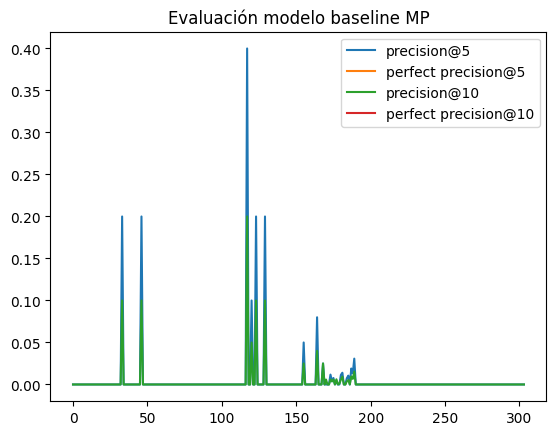

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.000000,0.0,0.0
mean,2022-07-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069180,NaN,NaN
min,2022-06-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067741,NaN,NaN
25%,2022-06-25 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068388,NaN,NaN
50%,2022-07-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069066,NaN,NaN
75%,2022-07-14 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069663,NaN,NaN
max,2022-07-24 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071717,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001132,NaN,NaN
